<a href="https://colab.research.google.com/github/Faroukmiyajr/machine-learning/blob/main/Brain_Tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#import libraries and tools
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random #for generating random values for augmentation
from PIL import Image, ImageEnhance #for image processing and enhancement
from tensorflow.keras.models import Sequential #for building the model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout #for model layers
from tensorflow.keras.preprocessing.image import load_img #for loading images
from tensorflow.keras.optimizers import Adam #for optimizer
from tensorflow.keras.applications import VGG16 #for using VGG16 model
from sklearn.utils import shuffle #for shuffling the data

In [ ]:
train_dir = '/content/drive/MyDrive/archive (5)/Training'
test_dir = '/content/drive/MyDrive/archive (5)/Testing'

#load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
      train_paths.append(os.path.join(train_dir, label, image))
      train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

#load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
      test_paths.append(os.path.join(test_dir, label, image))
      test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)




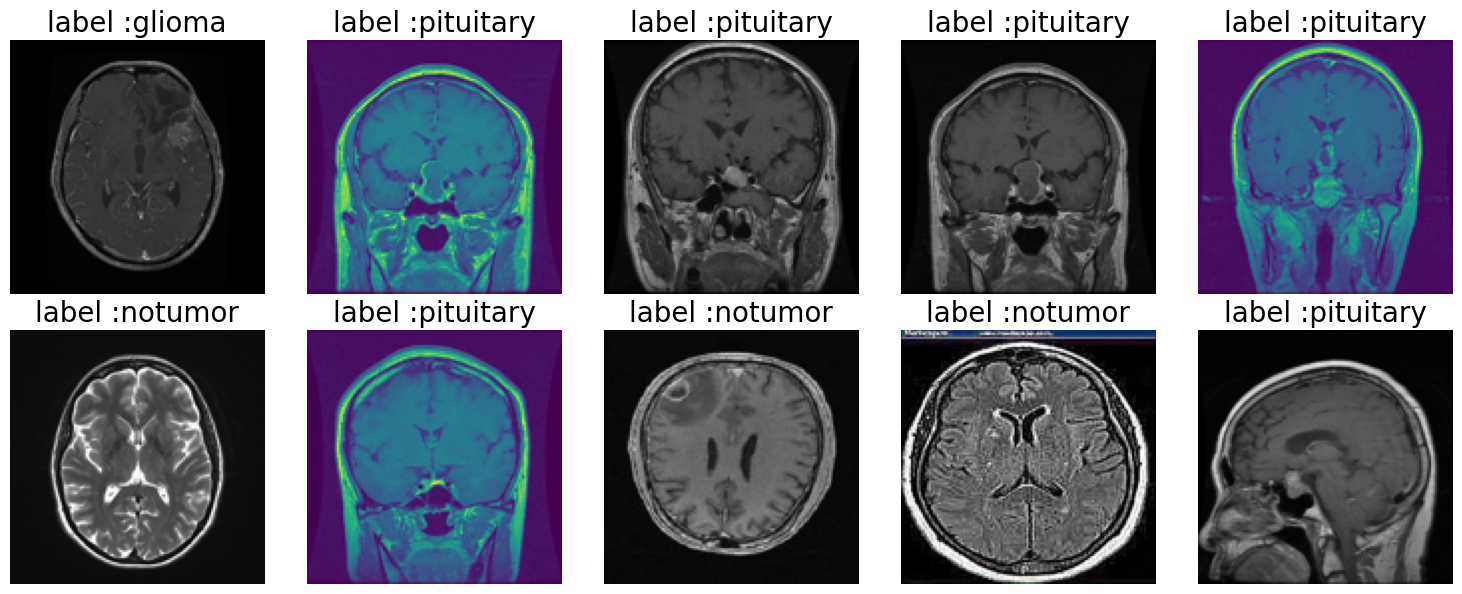

In [ ]:
#data visualization
import random
import matplotlib.pyplot as plt

#select random indicies for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

#create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

#loop through the random indices and display images
for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  #display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"label :{train_labels[idx]}",fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
#image preprocessing
#image augmentation function
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image =ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

#load images and apply augementation
def open_images(paths):
  images = []
  for path in paths:
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = augment_image(image)
    images.append(image)
  return np.array(images)

#encoder labels(convert label names to integers)
def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

#data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images, batch_labels







In [ ]:
os.listdir(train_dir)

['notumor', 'pituitary', 'glioma', 'meningioma']

In [ ]:
#model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

#freeze all layers of this VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

#set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#build model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

#parameters
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5

#train model
history = model.fit(datagen(train_paths, train_labels, batch_size = batch_size, epochs =epochs), steps_per_epoch=steps, epochs=epochs)




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 852s 5s/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8667
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - loss: 0.0731 - sparse_categorical_accuracy: 0.9720
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 827s 5s/step - loss: 0.0523 - sparse_categorical_accuracy: 0.9790
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 832s 5s/step - loss: 0.0260 - sparse_categorical_accuracy: 0.9906
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 827s 5s/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9931


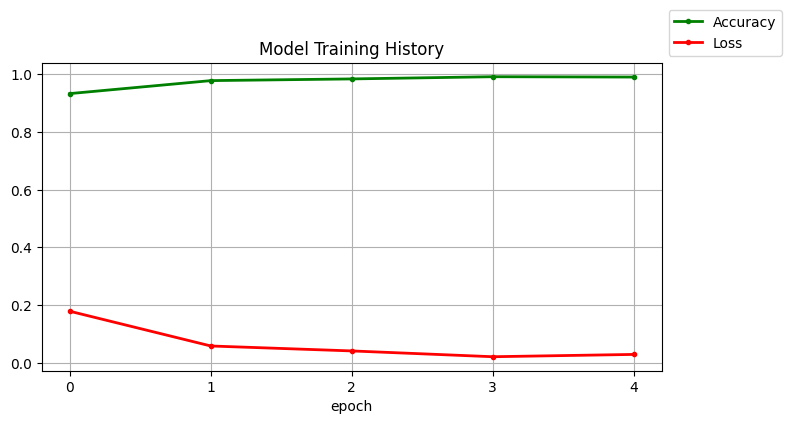

In [ ]:
#train and val plots
import random #for generating random values for augmentation
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'.g-',linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='lower left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
#model classification report
from sklearn.metrics import classification_report,confusion_matrix, roc_curve,auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))





10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step
classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.87      0.93       300

    accuracy                           0.87       300
   macro avg       0.33      0.29      0.31       300
weighted avg       1.00      0.87      0.93       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[  0   0   0]
 [  0   0   0]
 [  1  38 261]]


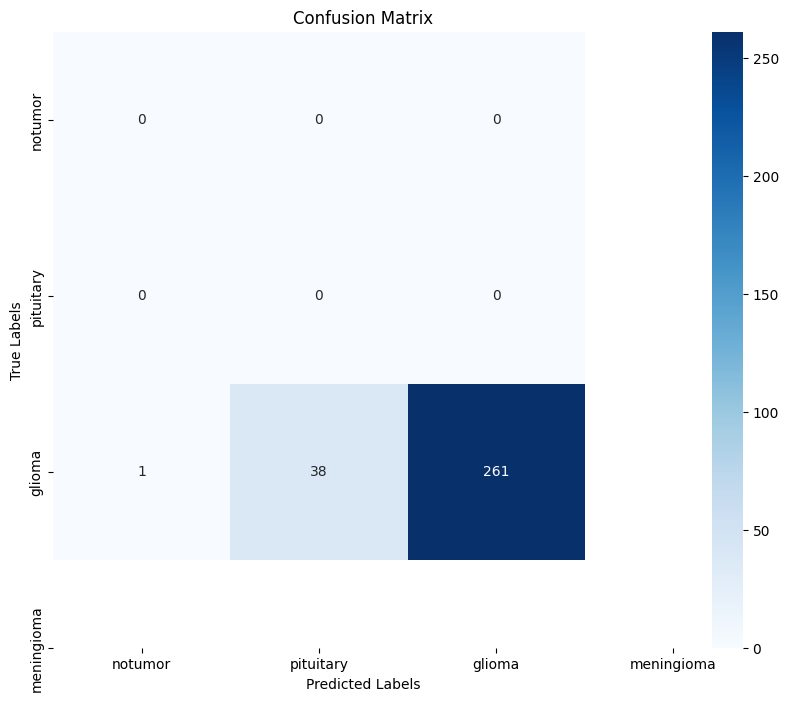

In [ ]:
#model confusion plot
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#save entire model
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
def detect_and_display(image_path,model):
  try:
    #load image
    image = load_img(image_path, target_size=(128, 128))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    #prediction
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis=1)[0]

    #display the image
    plt.imshow(image)
    plt.axis('off')
    #determine the class
    if class_labels[predicted_class_index] == 'no_tumor':
      result = 'No Tumor Detected'
    else:
      result = f'Tumor Detected: {class_labels[predicted_class_index]}'
      #display
      plt.imshow(load_img(image_path))
      plt.axis('off')
      plt.show()
  except Exception as e:
    print('Error processing the image:', str(e))



In [ ]:
!zip -r my_project.zip /content/
from google.colab import files
files.download('my_project.zip')


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.10.24/ (stored 0%)
  adding: content/.config/logs/2025.10.24/13.37.05.626629.log (deflated 86%)
  adding: content/.config/logs/2025.10.24/13.37.20.387601.log (deflated 57%)
  adding: content/.config/logs/2025.10.24/13.36.28.345286.log (deflated 92%)
  adding: content/.config/logs/2025.10.24/13.36.56.680283.log (deflated 58%)
  adding: content/.config/logs/2025.10.24/13.37.11.494884.log (deflated 58%)
  addi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>